# Predict cell fates using the CNN-RNN approach

To predict cell fates using our approach, we need the `caffe` framework (to extract features) as well as `Theano` (to do the acutal prediction). To install caffe, first clone our fork from [here](https://github.com/flophys/caffe) (providing full support for concatenation layer).  Then follow stanard `caffe`  installation instructions that can be found [here](http://caffe.berkeleyvision.org/installation.html). `Theano` can be installed following the instructions detailed [here](http://deeplearning.net/software/theano/install.html). We recommend using the Anaconda distribution for an easy installation process of both `Theano` and `caffe`.
Predictions are not computationally expensive and can be performed using CPU on a standard laptop (no cuda/GPU requiured to run this notebook).

In [15]:
import os
import glob
import scipy as SP
import sys
import pickle
from sklearn import metrics

caffe_root = '/Users/flo/software/caffe/'  #root directory of the caffe installation
sys.path.append(caffe_root + 'python')
sys.path.append('./')

import caffe
import py.extract_features as extr#import mat2dict, extract
from py.rnn import RNN
%matplotlib inline


Having loaded the required packages, we load the sample images and displacement features generated with the matlab scripts, which form a small subset of all images in the test set of round 1. In addition, we also provide a pickeled version of all image patches in this test set. 

In [2]:
reload(extr)
####load all annotated inmages in the test set#### 
pickle_file = '../processes_data/images_round3_test_annotated.pickle' #path to the pickled image patches
ims = extr.load_pickle(pickle_file)

####load the subset of images#### 
#mat_files = glob.glob('../processes_data/cell*.mat') #path to the cell for which we would like to obtain a fate prediction
#ims = extr.load_mat(mat_files) #load images and displacement features from matlab file into dictionary

Next, we extract the CNN-features for a given cell, using a pre-trained network we provide.



In [3]:
PRETRAINED = './models/cnn_models/round_3/trained_CNN.caffemodel' #path to the pretrained model
MODEL_FILE = os.path.join('./models/cnn_models/','CNN_deploy.prototxt') #model file specifying the architecture 
                                                                        #of the pre-trained model

feat_list = []
labels = []
predsCNN = []
nCells = len(ims['im'])
for i in range(nCells):
    res = extr.extract(pretrained=PRETRAINED, model_file=MODEL_FILE, input_image_test=ims['im'][i], 
                  displacement_test=ims['mov'][i])#extract the CNN features
    feat_list.append(res['feats'])
    labels.append(ims['label'][i])
    predsCNN.append(res['pred_all'].mean())
    if SP.mod(i+1,50)==0 or (i+1)==(nCells):
        print('%i/%i cells processed' % (i+1,nCells))




50/1056 cells processed
100/1056 cells processed
150/1056 cells processed
200/1056 cells processed
250/1056 cells processed
300/1056 cells processed
350/1056 cells processed
400/1056 cells processed
450/1056 cells processed
500/1056 cells processed
550/1056 cells processed
600/1056 cells processed
650/1056 cells processed
700/1056 cells processed
750/1056 cells processed
800/1056 cells processed
850/1056 cells processed
900/1056 cells processed
950/1056 cells processed
1000/1056 cells processed
1050/1056 cells processed
1056/1056 cells processed


We can next pass these image-patch specific features into the RNN-part of the model and get a cell-specific prediction based on CNN features. To this end, we first populate the RNN with the pre-trained parameters. Next we pass t

In [5]:
fn = './models/rnn_models/round_3/trained_modelRNN.pkl'#pre-trained model

#load model parameters
f = open(fn, 'rb')
[structure, weights] = pickle.load(f)

#populate model
model = RNN(structure[0], structure[1], structure[2], 'dblstm')
model.set_theta(weights)

#run prediction
pred = model.predict(feat_list) #predict from CNN-based features


OK


Finally, we can evaluate the model perfromacne on the test set by calculating the macro-averaged F1 score and plot an ROC curve

Macro averaged F1 score 0.79:


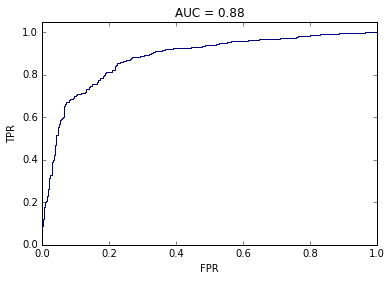

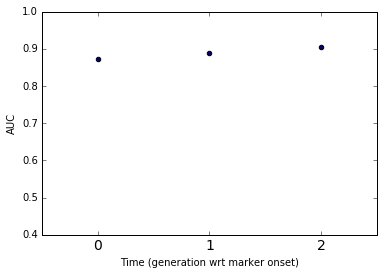

In [16]:
reload(extr)


F1 = metrics.f1_score(SP.vstack(labels).ravel().astype('int'),pred.ravel()>.5, average="macro")
print('Macro averaged F1 score %1.2f:' % F1)

extr.plotPerfromanceCurve(pred.ravel(),  SP.vstack(labels).ravel())
extr.plotAUC(pred.ravel(),  SP.vstack(labels).ravel(), is_annotated=True)


